# 导入模块 

In [1]:
#导入模块
import math
import random
import numpy as np
import pandas as pd
from xgboost import plot_tree
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold#这个函数只能用于
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error # 均方误差
from sklearn.metrics import r2_score 
from catboost import CatBoostRegressor

# 数据清理 

In [4]:
from sklearn import cross_validation

ImportError: cannot import name 'cross_validation' from 'sklearn' (D:\4_code\1_anaconda\envs\python38\lib\site-packages\sklearn\__init__.py)

In [3]:
data = pd.read_excel('Data.xlsx')
data1 = np.array(data)
X = data1[ : , :5]
Y = data1[ : ,5: ].flatten()
L = []
for i in Y :
    if i >= data.mean()[6]:
        L.append(1)
    else :
        L.append(0)
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,L,train_size=0.8)
x_train

array([[28.5152    ,  0.6       , 15.        , 90.        ,  0.179     ],
       [22.0779    ,  0.66666667, 15.        , 90.        ,  0.602     ],
       [30.098     ,  0.6       , 10.        , 90.        ,  0.179     ],
       ...,
       [11.8       ,  0.6       , 20.        , 90.        ,  1.065     ],
       [11.8       ,  0.54545455, 15.        , 60.        ,  0.179     ],
       [20.7       ,  0.66666667, 10.        , 60.        ,  1.065     ]])

# 模型建立及调参
+ 计算MSE RMSE R@2的值
+ 绘制
    + 决策树图
    + 特征重要性
    + 反映R方

## GBDT

### 调参

In [65]:
from sklearn.model_selection import StratifiedKFold#这个函数只能用于

paramgrid = {"learning_rate": [i*0.01 for i in range(1,21)],
             "n_estimators" : range(100,1100,100),
             "max_depth" : range(3,11)}

random.seed(1)

from evolutionary_search import EvolutionaryAlgorithmSearchCV
cv = EvolutionaryAlgorithmSearchCV(estimator=GradientBoostingRegressor(),
                                   params=paramgrid, #超参数搜索空间
                                   scoring="roc_auc", #accuracy的标准
                                   cv=StratifiedKFold(n_splits=5), #交叉验证4折
                                   verbose=1,
                                   population_size=50, #整个种群的染色体数目为50个超参数组合
                                   gene_mutation_prob=0.10, #我们的“孩子”超参数组合中每次会大概选择出10%的超参数进行随机取值
                                   gene_crossover_prob=0.5, #我们会选择每一条“父母”染色体（超参数组合）中的50%的基因（超参数）进行相互交叉
                                   tournament_size=3, #每次从上一代中选择出适应度最好的3个超参数组合直接进行 “复制”
                                   generations_number=5,
                                   n_jobs=1)
cv.fit(X, L)

# Best individual is: {'learning_rate': 0.03, 'n_estimators': 200, 'max_depth': 3}
# with fitness: 0.9369579345172885

D:\4_code\1_anaconda\envs\python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
D:\4_code\1_anaconda\envs\python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Types [2, 1, 1] and maxint [19, 9, 7] detected
--- Evolve in 1600 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	50    	0.908336	0.873763	0.935671	0.0146158
1  	35    	0.919102	0.897001	0.935671	0.00832614
2  	27    	0.925048	0.906964	0.935671	0.00644491
3  	22    	0.929408	0.906423	0.936958	0.00640239
4  	37    	0.932137	0.905154	0.936958	0.00595983
5  	28    	0.934318	0.910192	0.936958	0.0041444 
Best individual is: {'learning_rate': 0.03, 'n_estimators': 200, 'max_depth': 3}
with fitness: 0.9369579345172885


In [66]:
# 使用调好的参数进行训练
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=3, min_samples_split=2, learning_rate=0.03)
gbr.fit(x_train, y_train)

y_predict = gbr.predict(x_test)
MSE = mean_squared_error(y_test,y_predict)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_test,y_predict)
print(f'MSE的值为{MSE},RMSE为{RMSE},R2为{R2}')

MSE的值为0.12183156399540798,RMSE为0.3490437852124114,R2为0.512093593713628


### 特征图

1    0.086280
2    0.118109
3    0.710922
4    0.065477
5    0.019212
dtype: float64
5    0.019212
4    0.065477
1    0.086280
2    0.118109
3    0.710922
dtype: float64
[5, 4, 1, 2, 3]
[0.01921207 0.06547714 0.08627959 0.11810937 0.71092184]


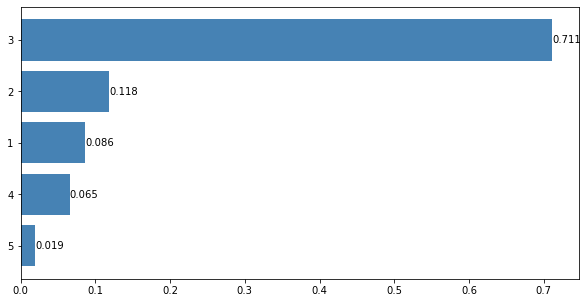

In [67]:
#绘制特征重要性
import matplotlib.pyplot as plt
importance = gbr.feature_importances_
#获取特征标签
Impt_Series = pd.Series(importance, index = data.iloc[:,:5].columns)
print(Impt_Series)


#对特征影响大小进行排列
# Impt_Series.sort_values(ascending = True).plot('barh')
Impt_Series = Impt_Series.sort_values(ascending = True)

print(Impt_Series)
print(list(Impt_Series.index))
Y = list(Impt_Series.index)
# 绘制条形图
plt.figure(figsize=(10,5)) 
plt.barh(range(len(Y)), # 指定条形图y轴的刻度值
        Impt_Series.values, # 指定条形图x轴的数值
        tick_label = Y, # 指定条形图y轴的刻度标签
        color = 'steelblue', # 指定条形图的填充色
       )

print(Impt_Series.values)
# print()
for y,x in enumerate(Impt_Series.values):
    plt.text(x+0.0001,y,'%s' %round(x,3),va='center')
plt.show()

## XGBoost

### 调参 

In [68]:
data = pd.read_excel('Data.xlsx')
data = np.array(data)
## 乱序
from sklearn.utils import shuffle
data = shuffle(data)

## 划分训练集 验证集
X = data[ : , :5]
Y = data[ : ,5: ].flatten()
L = []
for i in Y :
    if i >= 1:
        L.append(1)
    else :
        L.append(0)
import random
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold#这个函数只能用于

paramgrid = {"learning_rate": [i*0.01 for i in range(1,21)],
             "n_estimators" : range(100,1100,100),
             "max_depth" : range(3,11),
             "min_child_weight":range(1,9)}

random.seed(1)

from evolutionary_search import EvolutionaryAlgorithmSearchCV
cv = EvolutionaryAlgorithmSearchCV(estimator=XGBRegressor(),
                                   params=paramgrid, #超参数搜索空间
                                   scoring="roc_auc", #accuracy的标准
                                   cv=StratifiedKFold(n_splits=5), #交叉验证4折
                                   verbose=1,
                                   population_size=50, #整个种群的染色体数目为50个超参数组合
                                   gene_mutation_prob=0.10, #我们的“孩子”超参数组合中每次会大概选择出10%的超参数进行随机取值
                                   gene_crossover_prob=0.5, #我们会选择每一条“父母”染色体（超参数组合）中的50%的基因（超参数）进行相互交叉
                                   tournament_size=3, #每次从上一代中选择出适应度最好的3个超参数组合直接进行 “复制”
                                   generations_number=5,
                                   n_jobs=1)
cv.fit(X, L)

# Best individual is: {'learning_rate': 0.03, 'n_estimators': 300, 'max_depth': 6, 'min_child_weight': 7}
# with fitness: 0.948133941178296

D:\4_code\1_anaconda\envs\python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
D:\4_code\1_anaconda\envs\python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Types [2, 1, 1, 1] and maxint [19, 9, 7, 7] detected
--- Evolve in 12800 possible combinations ---
gen	nevals	avg    	min     	max     	std       
0  	50    	0.93439	0.923533	0.947668	0.00610132
1  	24    	0.940149	0.924294	0.947668	0.00459743
2  	35    	0.942643	0.926047	0.947668	0.00429052
3  	24    	0.946232	0.939878	0.947668	0.00185243
4  	27    	0.947116	0.940087	0.948134	0.00136368
5  	22    	0.947266	0.937659	0.947668	0.00157362
Best individual is: {'learning_rate': 0.03, 'n_estimators': 300, 'max_depth': 6, 'min_child_weight': 7}
with fitness: 0.948133941178296


In [69]:
from xgboost import XGBRegressor
xgst=XGBRegressor(learning_rate=0.03,n_estimators=300,max_depth=6,min_child_weight=7)
xgst.fit(x_train, y_train)

y_predict = xgst.predict(x_test)
MSE = mean_squared_error(y_test,y_predict)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_test,y_predict)
print(f'MSE的值为{MSE},RMSE为{RMSE},R2为{R2}')

MSE的值为0.11467015143793013,RMSE为0.33862981475045895,R2为0.5407733459080988


### 决策树

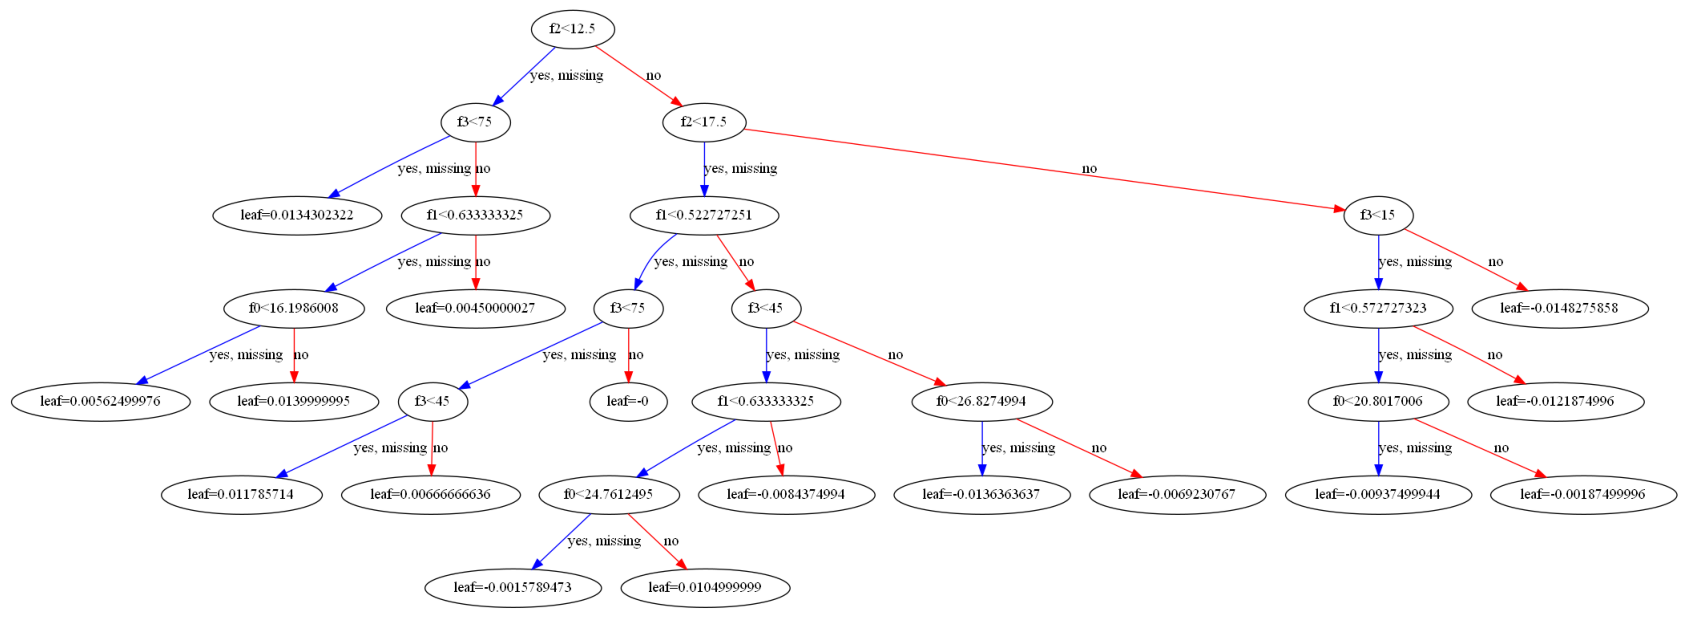

In [70]:
#绘制决策树图
plot_tree(xgst)
fig = plt.gcf()
fig.set_size_inches(30, 15)

### 特征图

1    0.026239
2    0.096645
3    0.765115
4    0.062667
5    0.049334
dtype: float32
1    0.026239
5    0.049334
4    0.062667
2    0.096645
3    0.765115
dtype: float32
[1, 5, 4, 2, 3]
[0.02623894 0.0493338  0.06266734 0.09664529 0.76511455]


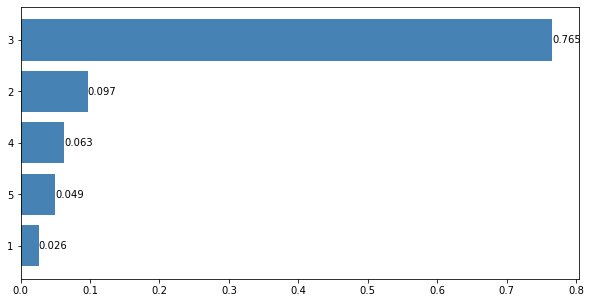

In [74]:
#绘制特征重要性
importance = xgst.feature_importances_
#获取特征标签
Impt_Series = pd.Series(importance, index = data.iloc[:,:5].columns)
print(Impt_Series)


#对特征影响大小进行排列
# Impt_Series.sort_values(ascending = True).plot('barh')
Impt_Series = Impt_Series.sort_values(ascending = True)

print(Impt_Series)
print(list(Impt_Series.index))
Y = list(Impt_Series.index)
# 绘制条形图
plt.figure(figsize=(10,5)) 
plt.barh(range(len(Y)), # 指定条形图y轴的刻度值
        Impt_Series.values, # 指定条形图x轴的数值
        tick_label = Y, # 指定条形图y轴的刻度标签
        color = 'steelblue', # 指定条形图的填充色
       )

print(Impt_Series.values)
# print()
for y,x in enumerate(Impt_Series.values):
    plt.text(x+0.0001,y,'%s' %round(x,3),va='center')
plt.show()

## LightGBM

### 调参

In [80]:
data = pd.read_excel('Data.xlsx')
data = np.array(data)
## 乱序
from sklearn.utils import shuffle
data = shuffle(data)

## 划分训练集 验证集
X = data[ : , :5]
Y = data[ : ,5: ].flatten()
L = []
for i in Y :
    if i >= 1:
        L.append(1)
    else :
        L.append(0)




paramgrid = {"learning_rate": [i*0.01 for i in range(1,21)],
             "n_estimators" : range(100,1100,100),
             "max_depth" : range(3,11),
             "min_child_weight":range(1,9)}

random.seed(1)

from evolutionary_search import EvolutionaryAlgorithmSearchCV
cv = EvolutionaryAlgorithmSearchCV(estimator=LGBMRegressor(objective='regression'),
                                   params=paramgrid, #超参数搜索空间
                                   scoring="roc_auc", #accuracy的标准
                                   cv=StratifiedKFold(n_splits=5), #交叉验证4折
                                   verbose=1,
                                   population_size=50, #整个种群的染色体数目为50个超参数组合
                                   gene_mutation_prob=0.10, #我们的“孩子”超参数组合中每次会大概选择出10%的超参数进行随机取值
                                   gene_crossover_prob=0.5, #我们会选择每一条“父母”染色体（超参数组合）中的50%的基因（超参数）进行相互交叉
                                   tournament_size=3, #每次从上一代中选择出适应度最好的3个超参数组合直接进行 “复制”
                                   generations_number=5,
                                   n_jobs=1)
cv.fit(X, L)

# Best individual is: {'learning_rate': 0.05, 'n_estimators': 100, 'max_depth': 3, 'min_child_weight': 4}
# with fitness: 0.9288180867817964

D:\4_code\1_anaconda\envs\python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
D:\4_code\1_anaconda\envs\python38\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Types [2, 1, 1, 1] and maxint [19, 9, 7, 7] detected
--- Evolve in 12800 possible combinations ---
gen	nevals	avg     	min     	max     	std       
0  	50    	0.914475	0.901411	0.928818	0.00815708
1  	24    	0.920844	0.898765	0.928703	0.00680329
2  	37    	0.922927	0.90178 	0.928703	0.00648017
3  	24    	0.927535	0.91951 	0.928703	0.00215127
4  	23    	0.928432	0.915526	0.928703	0.00184447
5  	29    	0.928456	0.91798 	0.928703	0.00150802
Best individual is: {'learning_rate': 0.05, 'n_estimators': 100, 'max_depth': 3, 'min_child_weight': 4}
with fitness: 0.9288180867817964


In [83]:
import lightgbm as lgb

lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'max_depth': 3,
    'min_child_weight': ,
    'force_col_wise': 'true'
}

# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100, #'num_iterations ' :100
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

y_predict = gbm.predict(x_test)
MSE = mean_squared_error(y_test,y_predict)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_test,y_predict)
print(f'MSE的值为{MSE},RMSE为{RMSE},R2为{R2}')


[1]	valid_0's l2: 0.234225	valid_0's l1: 0.483211
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.223301	valid_0's l1: 0.471141
[3]	valid_0's l2: 0.213193	valid_0's l1: 0.459343
[4]	valid_0's l2: 0.204402	valid_0's l1: 0.448439
[5]	valid_0's l2: 0.195937	valid_0's l1: 0.437798
[6]	valid_0's l2: 0.188742	valid_0's l1: 0.428009
[7]	valid_0's l2: 0.1826	valid_0's l1: 0.41901
[8]	valid_0's l2: 0.176885	valid_0's l1: 0.410191
[9]	valid_0's l2: 0.17203	valid_0's l1: 0.402072
[10]	valid_0's l2: 0.16749	valid_0's l1: 0.394107
[11]	valid_0's l2: 0.162307	valid_0's l1: 0.385808
[12]	valid_0's l2: 0.158368	valid_0's l1: 0.378129
[13]	valid_0's l2: 0.15366	valid_0's l1: 0.369912
[14]	valid_0's l2: 0.150538	valid_0's l1: 0.362958
[15]	valid_0's l2: 0.146641	valid_0's l1: 0.355477
[16]	valid_0's l2: 0.14239	valid_0's l1: 0.347937
[17]	valid_0's l2: 0.138684	valid_0's l1: 0.340968
[18]	valid_0's l2: 0.135198	valid_0's l1: 0.334052
[19]	valid_0's l2: 0.132209	valid_0's 

### 决策树

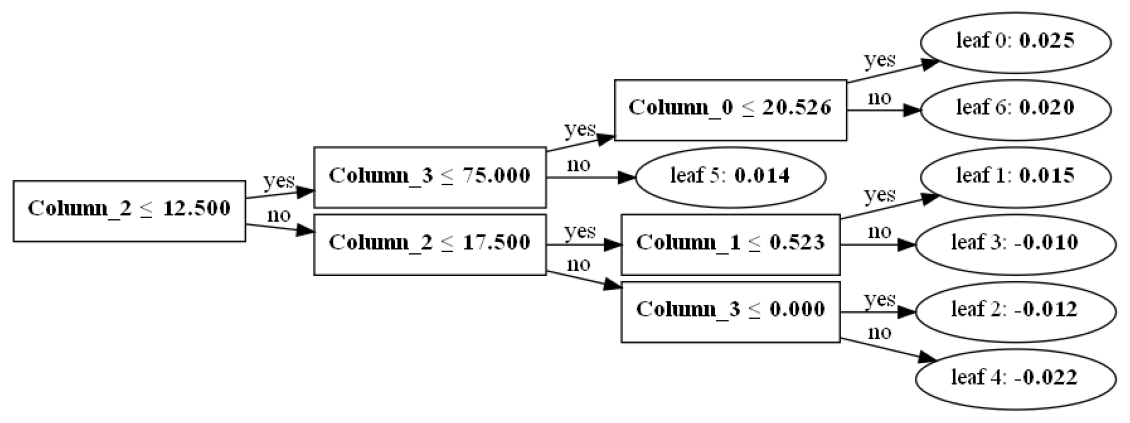

In [84]:
fig2 = plt.figure(figsize=(20, 20))
ax = fig2.subplots()
lgb.plot_tree(gbm, tree_index=1, ax=ax)
plt.show()

### 特征图

1    0.172477
2    0.229358
3    0.187156
4    0.177982
5    0.100917
dtype: float64
5    0.100917
1    0.172477
4    0.177982
3    0.187156
2    0.229358
dtype: float64
[5, 1, 4, 3, 2]
[0.10091743 0.17247706 0.17798165 0.18715596 0.2293578 ]


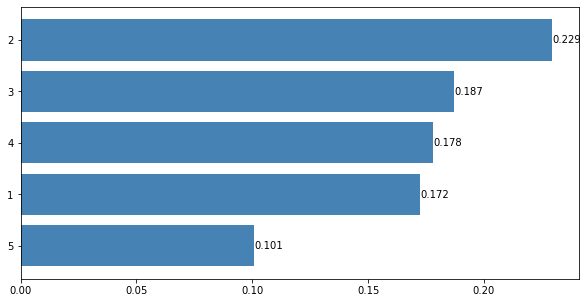

In [87]:
#绘制特征重要性
importance = gbm.feature_importance()/545
#获取特征标签
Impt_Series = pd.Series(importance, index = data.iloc[:,:5].columns)
print(Impt_Series)


#对特征影响大小进行排列
# Impt_Series.sort_values(ascending = True).plot('barh')
Impt_Series = Impt_Series.sort_values(ascending = True)

print(Impt_Series)
print(list(Impt_Series.index))
Y = list(Impt_Series.index)
# 绘制条形图
plt.figure(figsize=(10,5)) 
plt.barh(range(len(Y)), # 指定条形图y轴的刻度值
        Impt_Series.values, # 指定条形图x轴的数值
        tick_label = Y, # 指定条形图y轴的刻度标签
        color = 'steelblue', # 指定条形图的填充色
       )

print(Impt_Series.values)
# print()
for y,x in enumerate(Impt_Series.values):
    plt.text(x+0.0001,y,'%s' %round(x,3),va='center')
plt.show()

## CatBoost 

### 调参

In [ ]:
data = pd.read_excel('Data.xlsx')
data = np.array(data)
## 乱序
from sklearn.utils import shuffle
data = shuffle(data)

## 划分训练集 验证集
X = data[ : , :5]
Y = data[ : ,5: ].flatten()
L = []
for i in Y :
    if i >= 1:
        L.append(1)
    else :
        L.append(0)

paramgrid = {"learning_rate": [i*0.01 for i in range(1,21)],
             "iterations" : range(100,1100,100),
             "max_depth" : range(3,11),
             "l2_leaf_reg":range(1,6)}

random.seed(1)

from evolutionary_search import EvolutionaryAlgorithmSearchCV
cv = EvolutionaryAlgorithmSearchCV(estimator=CatBoostRegressor(),
                                   params=paramgrid, #超参数搜索空间
                                   scoring="roc_auc", #accuracy的标准
                                   cv=StratifiedKFold(n_splits=5), #交叉验证4折
                                   verbose=1,
                                   population_size=50, #整个种群的染色体数目为50个超参数组合
                                   gene_mutation_prob=0.10, #我们的“孩子”超参数组合中每次会大概选择出10%的超参数进行随机取值
                                   gene_crossover_prob=0.5, #我们会选择每一条“父母”染色体（超参数组合）中的50%的基因（超参数）进行相互交叉
                                   tournament_size=3, #每次从上一代中选择出适应度最好的3个超参数组合直接进行 “复制”
                                   generations_number=5,
                                   n_jobs=1)
cv.fit(X, L)


In [99]:
from catboost import CatBoostRegressor
model = CatBoostRegressor()

grid = {'learning_rate': [i*0.01 for i in range(1,21)],
        'depth': range(3,11),
        'l2_leaf_reg': [1, 2, 3, 4, 5],
       'iterations': range(100,1100,100)}

randomized_search_result = model.randomized_search(grid,
                                                   X=x_train,
                                                   y=y_train,
                                                   plot=True)


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6178566	test: 0.6190406	best: 0.6190406 (0)	total: 708us	remaining: 354ms
1:	learn: 0.5679038	test: 0.5679879	best: 0.5679879 (1)	total: 1.17ms	remaining: 290ms
2:	learn: 0.5232927	test: 0.5236183	best: 0.5236183 (2)	total: 1.39ms	remaining: 230ms
3:	learn: 0.4862720	test: 0.4878403	best: 0.4878403 (3)	total: 1.73ms	remaining: 215ms
4:	learn: 0.4537799	test: 0.4536662	best: 0.4536662 (4)	total: 2.07ms	remaining: 205ms
5:	learn: 0.4285977	test: 0.4315485	best: 0.4315485 (5)	total: 2.41ms	remaining: 199ms
6:	learn: 0.4052653	test: 0.4081002	best: 0.4081002 (6)	total: 2.73ms	remaining: 192ms
7:	learn: 0.3869651	test: 0.3917025	best: 0.3917025 (7)	total: 3.04ms	remaining: 187ms
8:	learn: 0.3723956	test: 0.3777128	best: 0.3777128 (8)	total: 3.37ms	remaining: 184ms
9:	learn: 0.3603741	test: 0.3656885	best: 0.3656885 (9)	total: 3.7ms	remaining: 181ms
10:	learn: 0.3511288	test: 0.3569137	best: 0.3569137 (10)	total: 4.04ms	remaining: 180ms
11:	learn: 0.3438858	test: 0.3508950	best: 

0:	learn: 0.6410834	test: 0.6455368	best: 0.6455368 (0)	total: 611us	remaining: 60.5ms
1:	learn: 0.6076562	test: 0.6149886	best: 0.6149886 (1)	total: 1.26ms	remaining: 61.9ms
2:	learn: 0.5716750	test: 0.5795894	best: 0.5795894 (2)	total: 1.69ms	remaining: 54.6ms
3:	learn: 0.5398865	test: 0.5476245	best: 0.5476245 (3)	total: 1.96ms	remaining: 47ms
4:	learn: 0.5110365	test: 0.5188469	best: 0.5188469 (4)	total: 2.34ms	remaining: 44.5ms
5:	learn: 0.4867405	test: 0.4945887	best: 0.4945887 (5)	total: 2.56ms	remaining: 40.1ms
6:	learn: 0.4656452	test: 0.4749004	best: 0.4749004 (6)	total: 3.13ms	remaining: 41.6ms
7:	learn: 0.4467378	test: 0.4575836	best: 0.4575836 (7)	total: 3.77ms	remaining: 43.3ms
8:	learn: 0.4291561	test: 0.4419112	best: 0.4419112 (8)	total: 4.35ms	remaining: 43.9ms
9:	learn: 0.4130616	test: 0.4247497	best: 0.4247497 (9)	total: 4.77ms	remaining: 42.9ms
10:	learn: 0.4003527	test: 0.4128371	best: 0.4128371 (10)	total: 5.2ms	remaining: 42ms
11:	learn: 0.3881247	test: 0.3997373

205:	learn: 0.2034085	test: 0.2886863	best: 0.2886863 (205)	total: 118ms	remaining: 283ms
206:	learn: 0.2033525	test: 0.2887186	best: 0.2886863 (205)	total: 119ms	remaining: 282ms
207:	learn: 0.2033037	test: 0.2887114	best: 0.2886863 (205)	total: 119ms	remaining: 282ms
208:	learn: 0.2032840	test: 0.2887493	best: 0.2886863 (205)	total: 120ms	remaining: 282ms
209:	learn: 0.2029958	test: 0.2889305	best: 0.2886863 (205)	total: 120ms	remaining: 281ms
210:	learn: 0.2025863	test: 0.2888420	best: 0.2886863 (205)	total: 121ms	remaining: 281ms
211:	learn: 0.2025635	test: 0.2888392	best: 0.2886863 (205)	total: 122ms	remaining: 280ms
212:	learn: 0.2017040	test: 0.2890367	best: 0.2886863 (205)	total: 122ms	remaining: 280ms
213:	learn: 0.2015291	test: 0.2890446	best: 0.2886863 (205)	total: 123ms	remaining: 279ms
214:	learn: 0.2014398	test: 0.2890618	best: 0.2886863 (205)	total: 124ms	remaining: 279ms
215:	learn: 0.2013609	test: 0.2890654	best: 0.2886863 (205)	total: 124ms	remaining: 278ms
216:	learn

498:	learn: 0.1445876	test: 0.2982099	best: 0.2882716 (265)	total: 292ms	remaining: 118ms
499:	learn: 0.1444709	test: 0.2984515	best: 0.2882716 (265)	total: 293ms	remaining: 117ms
500:	learn: 0.1443703	test: 0.2985293	best: 0.2882716 (265)	total: 294ms	remaining: 117ms
501:	learn: 0.1443514	test: 0.2985628	best: 0.2882716 (265)	total: 294ms	remaining: 116ms
502:	learn: 0.1440507	test: 0.2989359	best: 0.2882716 (265)	total: 295ms	remaining: 115ms
503:	learn: 0.1439507	test: 0.2990254	best: 0.2882716 (265)	total: 295ms	remaining: 115ms
504:	learn: 0.1438074	test: 0.2990292	best: 0.2882716 (265)	total: 296ms	remaining: 114ms
505:	learn: 0.1437380	test: 0.2990914	best: 0.2882716 (265)	total: 297ms	remaining: 114ms
506:	learn: 0.1432760	test: 0.2992203	best: 0.2882716 (265)	total: 297ms	remaining: 113ms
507:	learn: 0.1432702	test: 0.2992467	best: 0.2882716 (265)	total: 298ms	remaining: 113ms
508:	learn: 0.1431010	test: 0.2993188	best: 0.2882716 (265)	total: 298ms	remaining: 112ms
509:	learn

64:	learn: 0.1463125	test: 0.3072936	best: 0.2990760 (34)	total: 51.8ms	remaining: 108ms
65:	learn: 0.1456594	test: 0.3075647	best: 0.2990760 (34)	total: 52.9ms	remaining: 107ms
66:	learn: 0.1442611	test: 0.3087087	best: 0.2990760 (34)	total: 53.9ms	remaining: 107ms
67:	learn: 0.1418462	test: 0.3079669	best: 0.2990760 (34)	total: 54.9ms	remaining: 107ms
68:	learn: 0.1410765	test: 0.3080410	best: 0.2990760 (34)	total: 55.8ms	remaining: 106ms
69:	learn: 0.1390462	test: 0.3066402	best: 0.2990760 (34)	total: 56.8ms	remaining: 105ms
70:	learn: 0.1384481	test: 0.3067922	best: 0.2990760 (34)	total: 57.8ms	remaining: 105ms
71:	learn: 0.1382652	test: 0.3069366	best: 0.2990760 (34)	total: 58.7ms	remaining: 104ms
72:	learn: 0.1340768	test: 0.3084764	best: 0.2990760 (34)	total: 59.5ms	remaining: 104ms
73:	learn: 0.1340073	test: 0.3084296	best: 0.2990760 (34)	total: 60.5ms	remaining: 103ms
74:	learn: 0.1334708	test: 0.3087775	best: 0.2990760 (34)	total: 61.4ms	remaining: 102ms
75:	learn: 0.1306245	

64:	learn: 0.1219389	test: 0.3042791	best: 0.2942180 (35)	total: 55.8ms	remaining: 202ms
65:	learn: 0.1193723	test: 0.3059665	best: 0.2942180 (35)	total: 56.8ms	remaining: 201ms
66:	learn: 0.1181441	test: 0.3061534	best: 0.2942180 (35)	total: 57.7ms	remaining: 201ms
67:	learn: 0.1177434	test: 0.3062809	best: 0.2942180 (35)	total: 58.6ms	remaining: 200ms
68:	learn: 0.1158318	test: 0.3065050	best: 0.2942180 (35)	total: 59.5ms	remaining: 199ms
69:	learn: 0.1142188	test: 0.3067148	best: 0.2942180 (35)	total: 60.3ms	remaining: 198ms
70:	learn: 0.1135989	test: 0.3066592	best: 0.2942180 (35)	total: 61.4ms	remaining: 198ms
71:	learn: 0.1120645	test: 0.3067745	best: 0.2942180 (35)	total: 62.3ms	remaining: 197ms
72:	learn: 0.1115013	test: 0.3066463	best: 0.2942180 (35)	total: 63.3ms	remaining: 197ms
73:	learn: 0.1104513	test: 0.3060975	best: 0.2942180 (35)	total: 64.2ms	remaining: 196ms
74:	learn: 0.1098178	test: 0.3062271	best: 0.2942180 (35)	total: 65.1ms	remaining: 195ms
75:	learn: 0.1093366	

258:	learn: 0.0357533	test: 0.3290089	best: 0.2942180 (35)	total: 234ms	remaining: 37ms
259:	learn: 0.0356388	test: 0.3290081	best: 0.2942180 (35)	total: 235ms	remaining: 36.1ms
260:	learn: 0.0355948	test: 0.3290163	best: 0.2942180 (35)	total: 236ms	remaining: 35.2ms
261:	learn: 0.0343595	test: 0.3289643	best: 0.2942180 (35)	total: 237ms	remaining: 34.4ms
262:	learn: 0.0342407	test: 0.3290216	best: 0.2942180 (35)	total: 238ms	remaining: 33.5ms
263:	learn: 0.0342273	test: 0.3290394	best: 0.2942180 (35)	total: 239ms	remaining: 32.6ms
264:	learn: 0.0340082	test: 0.3290317	best: 0.2942180 (35)	total: 240ms	remaining: 31.7ms
265:	learn: 0.0340024	test: 0.3290521	best: 0.2942180 (35)	total: 241ms	remaining: 30.7ms
266:	learn: 0.0338820	test: 0.3289438	best: 0.2942180 (35)	total: 241ms	remaining: 29.8ms
267:	learn: 0.0338183	test: 0.3287779	best: 0.2942180 (35)	total: 242ms	remaining: 28.9ms
268:	learn: 0.0336509	test: 0.3286200	best: 0.2942180 (35)	total: 243ms	remaining: 28ms
269:	learn: 0.

104:	learn: 0.1029072	test: 0.3086078	best: 0.3025516 (75)	total: 143ms	remaining: 673ms
105:	learn: 0.1028641	test: 0.3087751	best: 0.3025516 (75)	total: 144ms	remaining: 673ms
106:	learn: 0.1027789	test: 0.3087816	best: 0.3025516 (75)	total: 146ms	remaining: 672ms
107:	learn: 0.1026454	test: 0.3087092	best: 0.3025516 (75)	total: 147ms	remaining: 672ms
108:	learn: 0.1004436	test: 0.3094520	best: 0.3025516 (75)	total: 149ms	remaining: 671ms
109:	learn: 0.1002758	test: 0.3094000	best: 0.3025516 (75)	total: 151ms	remaining: 671ms
110:	learn: 0.0999117	test: 0.3098234	best: 0.3025516 (75)	total: 152ms	remaining: 670ms
111:	learn: 0.0995446	test: 0.3100146	best: 0.3025516 (75)	total: 153ms	remaining: 669ms
112:	learn: 0.0991508	test: 0.3098240	best: 0.3025516 (75)	total: 155ms	remaining: 668ms
113:	learn: 0.0983130	test: 0.3103545	best: 0.3025516 (75)	total: 157ms	remaining: 667ms
114:	learn: 0.0979022	test: 0.3104302	best: 0.3025516 (75)	total: 158ms	remaining: 667ms
115:	learn: 0.0977810

227:	learn: 0.0584098	test: 0.3239358	best: 0.3025516 (75)	total: 324ms	remaining: 529ms
228:	learn: 0.0583385	test: 0.3239282	best: 0.3025516 (75)	total: 326ms	remaining: 528ms
229:	learn: 0.0580372	test: 0.3239937	best: 0.3025516 (75)	total: 327ms	remaining: 527ms
230:	learn: 0.0578480	test: 0.3242182	best: 0.3025516 (75)	total: 329ms	remaining: 526ms
231:	learn: 0.0578106	test: 0.3242695	best: 0.3025516 (75)	total: 331ms	remaining: 524ms
232:	learn: 0.0577006	test: 0.3243040	best: 0.3025516 (75)	total: 332ms	remaining: 523ms
233:	learn: 0.0576838	test: 0.3243323	best: 0.3025516 (75)	total: 332ms	remaining: 520ms
234:	learn: 0.0575452	test: 0.3243280	best: 0.3025516 (75)	total: 334ms	remaining: 519ms
235:	learn: 0.0575384	test: 0.3243522	best: 0.3025516 (75)	total: 335ms	remaining: 517ms
236:	learn: 0.0574232	test: 0.3243582	best: 0.3025516 (75)	total: 336ms	remaining: 515ms
237:	learn: 0.0571708	test: 0.3245233	best: 0.3025516 (75)	total: 338ms	remaining: 513ms
238:	learn: 0.0565591

354:	learn: 0.0388565	test: 0.3296351	best: 0.3025516 (75)	total: 507ms	remaining: 350ms
355:	learn: 0.0388186	test: 0.3296647	best: 0.3025516 (75)	total: 509ms	remaining: 349ms
356:	learn: 0.0387459	test: 0.3296795	best: 0.3025516 (75)	total: 510ms	remaining: 347ms
357:	learn: 0.0384792	test: 0.3297245	best: 0.3025516 (75)	total: 512ms	remaining: 346ms
358:	learn: 0.0384616	test: 0.3297332	best: 0.3025516 (75)	total: 512ms	remaining: 344ms
359:	learn: 0.0384035	test: 0.3297429	best: 0.3025516 (75)	total: 513ms	remaining: 342ms
360:	learn: 0.0383553	test: 0.3297917	best: 0.3025516 (75)	total: 514ms	remaining: 341ms
361:	learn: 0.0381137	test: 0.3298555	best: 0.3025516 (75)	total: 515ms	remaining: 339ms
362:	learn: 0.0380815	test: 0.3298784	best: 0.3025516 (75)	total: 517ms	remaining: 337ms
363:	learn: 0.0380311	test: 0.3298864	best: 0.3025516 (75)	total: 519ms	remaining: 336ms
364:	learn: 0.0379917	test: 0.3299295	best: 0.3025516 (75)	total: 520ms	remaining: 335ms
365:	learn: 0.0377148

480:	learn: 0.0233108	test: 0.3308093	best: 0.3025516 (75)	total: 688ms	remaining: 170ms
481:	learn: 0.0230552	test: 0.3307646	best: 0.3025516 (75)	total: 690ms	remaining: 169ms
482:	learn: 0.0225528	test: 0.3307952	best: 0.3025516 (75)	total: 691ms	remaining: 167ms
483:	learn: 0.0225498	test: 0.3307992	best: 0.3025516 (75)	total: 693ms	remaining: 166ms
484:	learn: 0.0225377	test: 0.3308045	best: 0.3025516 (75)	total: 694ms	remaining: 165ms
485:	learn: 0.0222747	test: 0.3307415	best: 0.3025516 (75)	total: 696ms	remaining: 163ms
486:	learn: 0.0221235	test: 0.3308690	best: 0.3025516 (75)	total: 697ms	remaining: 162ms
487:	learn: 0.0221153	test: 0.3308917	best: 0.3025516 (75)	total: 699ms	remaining: 160ms
488:	learn: 0.0219780	test: 0.3308594	best: 0.3025516 (75)	total: 700ms	remaining: 159ms
489:	learn: 0.0219611	test: 0.3308619	best: 0.3025516 (75)	total: 702ms	remaining: 158ms
490:	learn: 0.0218937	test: 0.3308782	best: 0.3025516 (75)	total: 703ms	remaining: 156ms
491:	learn: 0.0217796

1:	learn: 0.5543476	test: 0.5660895	best: 0.5660895 (1)	total: 1.79ms	remaining: 715ms
2:	learn: 0.5006698	test: 0.5109834	best: 0.5109834 (2)	total: 2.46ms	remaining: 654ms
3:	learn: 0.4583582	test: 0.4755037	best: 0.4755037 (3)	total: 3.35ms	remaining: 668ms
4:	learn: 0.4235800	test: 0.4417429	best: 0.4417429 (4)	total: 3.62ms	remaining: 575ms
5:	learn: 0.3964306	test: 0.4198632	best: 0.4198632 (5)	total: 4.51ms	remaining: 597ms
6:	learn: 0.3711836	test: 0.3987163	best: 0.3987163 (6)	total: 5.44ms	remaining: 617ms
7:	learn: 0.3513653	test: 0.3795073	best: 0.3795073 (7)	total: 5.89ms	remaining: 583ms
8:	learn: 0.3375104	test: 0.3663923	best: 0.3663923 (8)	total: 6.29ms	remaining: 553ms
9:	learn: 0.3248522	test: 0.3562487	best: 0.3562487 (9)	total: 6.87ms	remaining: 543ms
10:	learn: 0.3119106	test: 0.3443025	best: 0.3443025 (10)	total: 8.43ms	remaining: 605ms
11:	learn: 0.3050525	test: 0.3385387	best: 0.3385387 (11)	total: 8.75ms	remaining: 575ms
12:	learn: 0.2966385	test: 0.3308998	be

134:	learn: 0.0821708	test: 0.3097468	best: 0.2941829 (67)	total: 184ms	remaining: 907ms
135:	learn: 0.0810849	test: 0.3103534	best: 0.2941829 (67)	total: 186ms	remaining: 907ms
136:	learn: 0.0810221	test: 0.3103517	best: 0.2941829 (67)	total: 187ms	remaining: 906ms
137:	learn: 0.0808992	test: 0.3103388	best: 0.2941829 (67)	total: 189ms	remaining: 905ms
138:	learn: 0.0792204	test: 0.3104693	best: 0.2941829 (67)	total: 190ms	remaining: 904ms
139:	learn: 0.0783096	test: 0.3107015	best: 0.2941829 (67)	total: 192ms	remaining: 904ms
140:	learn: 0.0781824	test: 0.3106561	best: 0.2941829 (67)	total: 193ms	remaining: 903ms
141:	learn: 0.0780313	test: 0.3106529	best: 0.2941829 (67)	total: 195ms	remaining: 902ms
142:	learn: 0.0778733	test: 0.3106057	best: 0.2941829 (67)	total: 196ms	remaining: 901ms
143:	learn: 0.0774582	test: 0.3106335	best: 0.2941829 (67)	total: 198ms	remaining: 900ms
144:	learn: 0.0764305	test: 0.3115622	best: 0.2941829 (67)	total: 199ms	remaining: 900ms
145:	learn: 0.0762835

261:	learn: 0.0408718	test: 0.3246837	best: 0.2941829 (67)	total: 366ms	remaining: 751ms
262:	learn: 0.0408590	test: 0.3246720	best: 0.2941829 (67)	total: 367ms	remaining: 750ms
263:	learn: 0.0407873	test: 0.3247117	best: 0.2941829 (67)	total: 369ms	remaining: 749ms
264:	learn: 0.0406269	test: 0.3246453	best: 0.2941829 (67)	total: 370ms	remaining: 748ms
265:	learn: 0.0405860	test: 0.3246996	best: 0.2941829 (67)	total: 372ms	remaining: 747ms
266:	learn: 0.0404730	test: 0.3247622	best: 0.2941829 (67)	total: 373ms	remaining: 745ms
267:	learn: 0.0404668	test: 0.3247584	best: 0.2941829 (67)	total: 374ms	remaining: 742ms
268:	learn: 0.0402926	test: 0.3247441	best: 0.2941829 (67)	total: 375ms	remaining: 741ms
269:	learn: 0.0401536	test: 0.3246829	best: 0.2941829 (67)	total: 377ms	remaining: 740ms
270:	learn: 0.0401418	test: 0.3246760	best: 0.2941829 (67)	total: 379ms	remaining: 739ms
271:	learn: 0.0400222	test: 0.3246785	best: 0.2941829 (67)	total: 380ms	remaining: 738ms
272:	learn: 0.0399683

389:	learn: 0.0206382	test: 0.3257694	best: 0.2941829 (67)	total: 547ms	remaining: 575ms
390:	learn: 0.0206058	test: 0.3257581	best: 0.2941829 (67)	total: 548ms	remaining: 573ms
391:	learn: 0.0200515	test: 0.3258080	best: 0.2941829 (67)	total: 550ms	remaining: 572ms
392:	learn: 0.0200189	test: 0.3258033	best: 0.2941829 (67)	total: 551ms	remaining: 571ms
393:	learn: 0.0199306	test: 0.3257867	best: 0.2941829 (67)	total: 553ms	remaining: 570ms
394:	learn: 0.0198378	test: 0.3257806	best: 0.2941829 (67)	total: 554ms	remaining: 568ms
395:	learn: 0.0197848	test: 0.3257920	best: 0.2941829 (67)	total: 556ms	remaining: 567ms
396:	learn: 0.0197816	test: 0.3257925	best: 0.2941829 (67)	total: 557ms	remaining: 566ms
397:	learn: 0.0193785	test: 0.3256996	best: 0.2941829 (67)	total: 559ms	remaining: 564ms
398:	learn: 0.0193720	test: 0.3256961	best: 0.2941829 (67)	total: 560ms	remaining: 563ms
399:	learn: 0.0192855	test: 0.3256932	best: 0.2941829 (67)	total: 562ms	remaining: 562ms
400:	learn: 0.0191322

514:	learn: 0.0129810	test: 0.3264227	best: 0.2941829 (67)	total: 728ms	remaining: 403ms
515:	learn: 0.0129712	test: 0.3264246	best: 0.2941829 (67)	total: 730ms	remaining: 402ms
516:	learn: 0.0129481	test: 0.3264101	best: 0.2941829 (67)	total: 731ms	remaining: 400ms
517:	learn: 0.0129346	test: 0.3264421	best: 0.2941829 (67)	total: 733ms	remaining: 399ms
518:	learn: 0.0125322	test: 0.3264749	best: 0.2941829 (67)	total: 734ms	remaining: 398ms
519:	learn: 0.0125305	test: 0.3264706	best: 0.2941829 (67)	total: 736ms	remaining: 396ms
520:	learn: 0.0123812	test: 0.3264628	best: 0.2941829 (67)	total: 737ms	remaining: 395ms
521:	learn: 0.0123245	test: 0.3264619	best: 0.2941829 (67)	total: 739ms	remaining: 394ms
522:	learn: 0.0123101	test: 0.3265133	best: 0.2941829 (67)	total: 740ms	remaining: 392ms
523:	learn: 0.0123046	test: 0.3265093	best: 0.2941829 (67)	total: 742ms	remaining: 391ms
524:	learn: 0.0121986	test: 0.3265109	best: 0.2941829 (67)	total: 744ms	remaining: 389ms
525:	learn: 0.0121634

636:	learn: 0.0080318	test: 0.3265722	best: 0.2941829 (67)	total: 910ms	remaining: 233ms
637:	learn: 0.0080271	test: 0.3265725	best: 0.2941829 (67)	total: 912ms	remaining: 232ms
638:	learn: 0.0080179	test: 0.3265929	best: 0.2941829 (67)	total: 913ms	remaining: 230ms
639:	learn: 0.0079953	test: 0.3265867	best: 0.2941829 (67)	total: 915ms	remaining: 229ms
640:	learn: 0.0079179	test: 0.3265858	best: 0.2941829 (67)	total: 916ms	remaining: 227ms
641:	learn: 0.0078332	test: 0.3266185	best: 0.2941829 (67)	total: 918ms	remaining: 226ms
642:	learn: 0.0078261	test: 0.3266363	best: 0.2941829 (67)	total: 919ms	remaining: 224ms
643:	learn: 0.0078221	test: 0.3266467	best: 0.2941829 (67)	total: 921ms	remaining: 223ms
644:	learn: 0.0077931	test: 0.3266399	best: 0.2941829 (67)	total: 922ms	remaining: 222ms
645:	learn: 0.0077687	test: 0.3266231	best: 0.2941829 (67)	total: 923ms	remaining: 220ms
646:	learn: 0.0077378	test: 0.3266343	best: 0.2941829 (67)	total: 925ms	remaining: 219ms
647:	learn: 0.0077341

758:	learn: 0.0053179	test: 0.3269339	best: 0.2941829 (67)	total: 1.09s	remaining: 58.9ms
759:	learn: 0.0053176	test: 0.3269341	best: 0.2941829 (67)	total: 1.09s	remaining: 57.5ms
760:	learn: 0.0052934	test: 0.3269230	best: 0.2941829 (67)	total: 1.09s	remaining: 56.1ms
761:	learn: 0.0052913	test: 0.3269206	best: 0.2941829 (67)	total: 1.09s	remaining: 54.7ms
762:	learn: 0.0052909	test: 0.3269184	best: 0.2941829 (67)	total: 1.1s	remaining: 53.2ms
763:	learn: 0.0052907	test: 0.3269180	best: 0.2941829 (67)	total: 1.1s	remaining: 51.7ms
764:	learn: 0.0052903	test: 0.3269178	best: 0.2941829 (67)	total: 1.1s	remaining: 50.3ms
765:	learn: 0.0052883	test: 0.3269227	best: 0.2941829 (67)	total: 1.1s	remaining: 48.9ms
766:	learn: 0.0052877	test: 0.3269236	best: 0.2941829 (67)	total: 1.1s	remaining: 47.4ms
767:	learn: 0.0052876	test: 0.3269233	best: 0.2941829 (67)	total: 1.1s	remaining: 46ms
768:	learn: 0.0052207	test: 0.3269239	best: 0.2941829 (67)	total: 1.1s	remaining: 44.6ms
769:	learn: 0.00521

70:	learn: 0.1844599	test: 0.3067303	best: 0.3067303 (70)	total: 125ms	remaining: 753ms
71:	learn: 0.1824998	test: 0.3070474	best: 0.3067303 (70)	total: 128ms	remaining: 758ms
72:	learn: 0.1805377	test: 0.3073197	best: 0.3067303 (70)	total: 130ms	remaining: 762ms
73:	learn: 0.1785276	test: 0.3077870	best: 0.3067303 (70)	total: 133ms	remaining: 765ms
74:	learn: 0.1782125	test: 0.3077588	best: 0.3067303 (70)	total: 133ms	remaining: 755ms
75:	learn: 0.1760589	test: 0.3078136	best: 0.3067303 (70)	total: 136ms	remaining: 758ms
76:	learn: 0.1743507	test: 0.3080673	best: 0.3067303 (70)	total: 139ms	remaining: 762ms
77:	learn: 0.1727726	test: 0.3077962	best: 0.3067303 (70)	total: 141ms	remaining: 765ms
78:	learn: 0.1713693	test: 0.3073745	best: 0.3067303 (70)	total: 144ms	remaining: 768ms
79:	learn: 0.1695069	test: 0.3082018	best: 0.3067303 (70)	total: 147ms	remaining: 770ms
80:	learn: 0.1693036	test: 0.3081870	best: 0.3067303 (70)	total: 147ms	remaining: 761ms
81:	learn: 0.1676079	test: 0.308

215:	learn: 0.0986435	test: 0.3072280	best: 0.3042612 (155)	total: 493ms	remaining: 648ms
216:	learn: 0.0978824	test: 0.3070670	best: 0.3042612 (155)	total: 496ms	remaining: 647ms
217:	learn: 0.0974498	test: 0.3073418	best: 0.3042612 (155)	total: 499ms	remaining: 645ms
218:	learn: 0.0973259	test: 0.3073815	best: 0.3042612 (155)	total: 502ms	remaining: 644ms
219:	learn: 0.0970053	test: 0.3074233	best: 0.3042612 (155)	total: 504ms	remaining: 642ms
220:	learn: 0.0969415	test: 0.3074328	best: 0.3042612 (155)	total: 507ms	remaining: 640ms
221:	learn: 0.0965444	test: 0.3075664	best: 0.3042612 (155)	total: 509ms	remaining: 638ms
222:	learn: 0.0965038	test: 0.3076000	best: 0.3042612 (155)	total: 512ms	remaining: 636ms
223:	learn: 0.0964383	test: 0.3076226	best: 0.3042612 (155)	total: 515ms	remaining: 634ms
224:	learn: 0.0964122	test: 0.3076153	best: 0.3042612 (155)	total: 517ms	remaining: 632ms
225:	learn: 0.0961358	test: 0.3076125	best: 0.3042612 (155)	total: 520ms	remaining: 630ms
226:	learn

354:	learn: 0.0673919	test: 0.3164638	best: 0.3042612 (155)	total: 868ms	remaining: 354ms
355:	learn: 0.0672621	test: 0.3164988	best: 0.3042612 (155)	total: 870ms	remaining: 352ms
356:	learn: 0.0670145	test: 0.3164630	best: 0.3042612 (155)	total: 873ms	remaining: 350ms
357:	learn: 0.0665595	test: 0.3166926	best: 0.3042612 (155)	total: 876ms	remaining: 347ms
358:	learn: 0.0665117	test: 0.3166941	best: 0.3042612 (155)	total: 879ms	remaining: 345ms
359:	learn: 0.0660838	test: 0.3167212	best: 0.3042612 (155)	total: 882ms	remaining: 343ms
360:	learn: 0.0657640	test: 0.3168232	best: 0.3042612 (155)	total: 884ms	remaining: 340ms
361:	learn: 0.0655625	test: 0.3167923	best: 0.3042612 (155)	total: 887ms	remaining: 338ms
362:	learn: 0.0653128	test: 0.3169184	best: 0.3042612 (155)	total: 890ms	remaining: 336ms
363:	learn: 0.0651614	test: 0.3169731	best: 0.3042612 (155)	total: 892ms	remaining: 333ms
364:	learn: 0.0650714	test: 0.3169257	best: 0.3042612 (155)	total: 895ms	remaining: 331ms
365:	learn

490:	learn: 0.0470945	test: 0.3219601	best: 0.3042612 (155)	total: 1.23s	remaining: 22.5ms
491:	learn: 0.0470245	test: 0.3219775	best: 0.3042612 (155)	total: 1.23s	remaining: 20ms
492:	learn: 0.0469500	test: 0.3220373	best: 0.3042612 (155)	total: 1.24s	remaining: 17.5ms
493:	learn: 0.0467031	test: 0.3220057	best: 0.3042612 (155)	total: 1.24s	remaining: 15ms
494:	learn: 0.0466745	test: 0.3220060	best: 0.3042612 (155)	total: 1.24s	remaining: 12.5ms
495:	learn: 0.0465859	test: 0.3219825	best: 0.3042612 (155)	total: 1.24s	remaining: 10ms
496:	learn: 0.0465472	test: 0.3219957	best: 0.3042612 (155)	total: 1.24s	remaining: 7.51ms
497:	learn: 0.0462930	test: 0.3221430	best: 0.3042612 (155)	total: 1.25s	remaining: 5.01ms
498:	learn: 0.0462560	test: 0.3222040	best: 0.3042612 (155)	total: 1.25s	remaining: 2.5ms
499:	learn: 0.0461996	test: 0.3222198	best: 0.3042612 (155)	total: 1.25s	remaining: 0us

bestTest = 0.3042611548
bestIteration = 155

7:	loss: 0.3042612	best: 0.2882716 (2)	total: 4.53s	re

31:	learn: 0.1162055	test: 0.3086226	best: 0.3045133 (24)	total: 86.6ms	remaining: 2.62s
32:	learn: 0.1105999	test: 0.3084853	best: 0.3045133 (24)	total: 92.2ms	remaining: 2.7s
33:	learn: 0.1049689	test: 0.3085607	best: 0.3045133 (24)	total: 97.9ms	remaining: 2.78s
34:	learn: 0.0998252	test: 0.3074014	best: 0.3045133 (24)	total: 103ms	remaining: 2.85s
35:	learn: 0.0957267	test: 0.3070409	best: 0.3045133 (24)	total: 109ms	remaining: 2.92s
36:	learn: 0.0940297	test: 0.3067368	best: 0.3045133 (24)	total: 114ms	remaining: 2.97s
37:	learn: 0.0893784	test: 0.3090635	best: 0.3045133 (24)	total: 120ms	remaining: 3.03s
38:	learn: 0.0845321	test: 0.3094565	best: 0.3045133 (24)	total: 125ms	remaining: 3.08s
39:	learn: 0.0815952	test: 0.3103050	best: 0.3045133 (24)	total: 131ms	remaining: 3.13s
40:	learn: 0.0802515	test: 0.3099910	best: 0.3045133 (24)	total: 133ms	remaining: 3.12s
41:	learn: 0.0783104	test: 0.3099869	best: 0.3045133 (24)	total: 139ms	remaining: 3.16s
42:	learn: 0.0743482	test: 0.3

138:	learn: 0.0157488	test: 0.3217266	best: 0.3045133 (24)	total: 639ms	remaining: 3.96s
139:	learn: 0.0156408	test: 0.3216786	best: 0.3045133 (24)	total: 645ms	remaining: 3.96s
140:	learn: 0.0154626	test: 0.3216515	best: 0.3045133 (24)	total: 646ms	remaining: 3.94s
141:	learn: 0.0153776	test: 0.3217331	best: 0.3045133 (24)	total: 652ms	remaining: 3.94s
142:	learn: 0.0153403	test: 0.3217417	best: 0.3045133 (24)	total: 654ms	remaining: 3.92s
143:	learn: 0.0151289	test: 0.3217764	best: 0.3045133 (24)	total: 660ms	remaining: 3.92s
144:	learn: 0.0150545	test: 0.3217986	best: 0.3045133 (24)	total: 662ms	remaining: 3.9s
145:	learn: 0.0149730	test: 0.3217569	best: 0.3045133 (24)	total: 667ms	remaining: 3.9s
146:	learn: 0.0144661	test: 0.3217168	best: 0.3045133 (24)	total: 673ms	remaining: 3.9s
147:	learn: 0.0142684	test: 0.3217427	best: 0.3045133 (24)	total: 678ms	remaining: 3.9s
148:	learn: 0.0142488	test: 0.3217510	best: 0.3045133 (24)	total: 683ms	remaining: 3.9s
149:	learn: 0.0141586	test

264:	learn: 0.0045463	test: 0.3227721	best: 0.3045133 (24)	total: 1.2s	remaining: 3.32s
265:	learn: 0.0045316	test: 0.3227678	best: 0.3045133 (24)	total: 1.2s	remaining: 3.31s
266:	learn: 0.0044674	test: 0.3227834	best: 0.3045133 (24)	total: 1.21s	remaining: 3.31s
267:	learn: 0.0044510	test: 0.3227906	best: 0.3045133 (24)	total: 1.21s	remaining: 3.31s
268:	learn: 0.0044396	test: 0.3227768	best: 0.3045133 (24)	total: 1.22s	remaining: 3.31s
269:	learn: 0.0044028	test: 0.3227590	best: 0.3045133 (24)	total: 1.22s	remaining: 3.31s
270:	learn: 0.0043780	test: 0.3227741	best: 0.3045133 (24)	total: 1.23s	remaining: 3.31s
271:	learn: 0.0042735	test: 0.3227738	best: 0.3045133 (24)	total: 1.24s	remaining: 3.31s
272:	learn: 0.0042559	test: 0.3227430	best: 0.3045133 (24)	total: 1.24s	remaining: 3.3s
273:	learn: 0.0042459	test: 0.3227381	best: 0.3045133 (24)	total: 1.24s	remaining: 3.3s
274:	learn: 0.0042210	test: 0.3227431	best: 0.3045133 (24)	total: 1.25s	remaining: 3.29s
275:	learn: 0.0041465	tes

380:	learn: 0.0011031	test: 0.3224873	best: 0.3045133 (24)	total: 1.75s	remaining: 2.83s
381:	learn: 0.0011014	test: 0.3224874	best: 0.3045133 (24)	total: 1.75s	remaining: 2.83s
382:	learn: 0.0010907	test: 0.3224868	best: 0.3045133 (24)	total: 1.75s	remaining: 2.82s
383:	learn: 0.0010743	test: 0.3224737	best: 0.3045133 (24)	total: 1.76s	remaining: 2.82s
384:	learn: 0.0010433	test: 0.3224566	best: 0.3045133 (24)	total: 1.76s	remaining: 2.82s
385:	learn: 0.0009801	test: 0.3224575	best: 0.3045133 (24)	total: 1.77s	remaining: 2.81s
386:	learn: 0.0009663	test: 0.3224496	best: 0.3045133 (24)	total: 1.77s	remaining: 2.81s
387:	learn: 0.0009655	test: 0.3224494	best: 0.3045133 (24)	total: 1.77s	remaining: 2.8s
388:	learn: 0.0009576	test: 0.3224554	best: 0.3045133 (24)	total: 1.78s	remaining: 2.79s
389:	learn: 0.0009568	test: 0.3224552	best: 0.3045133 (24)	total: 1.78s	remaining: 2.78s
390:	learn: 0.0009260	test: 0.3224546	best: 0.3045133 (24)	total: 1.78s	remaining: 2.78s
391:	learn: 0.0009254	

500:	learn: 0.0002131	test: 0.3224488	best: 0.3045133 (24)	total: 2.31s	remaining: 2.3s
501:	learn: 0.0002126	test: 0.3224490	best: 0.3045133 (24)	total: 2.31s	remaining: 2.29s
502:	learn: 0.0002118	test: 0.3224495	best: 0.3045133 (24)	total: 2.32s	remaining: 2.29s
503:	learn: 0.0002115	test: 0.3224500	best: 0.3045133 (24)	total: 2.32s	remaining: 2.29s
504:	learn: 0.0002101	test: 0.3224484	best: 0.3045133 (24)	total: 2.33s	remaining: 2.28s
505:	learn: 0.0002098	test: 0.3224488	best: 0.3045133 (24)	total: 2.33s	remaining: 2.28s
506:	learn: 0.0002078	test: 0.3224483	best: 0.3045133 (24)	total: 2.34s	remaining: 2.27s
507:	learn: 0.0002076	test: 0.3224483	best: 0.3045133 (24)	total: 2.34s	remaining: 2.27s
508:	learn: 0.0002072	test: 0.3224484	best: 0.3045133 (24)	total: 2.35s	remaining: 2.27s
509:	learn: 0.0002029	test: 0.3224479	best: 0.3045133 (24)	total: 2.35s	remaining: 2.26s
510:	learn: 0.0001999	test: 0.3224470	best: 0.3045133 (24)	total: 2.36s	remaining: 2.26s
511:	learn: 0.0001997	

615:	learn: 0.0000431	test: 0.3224429	best: 0.3045133 (24)	total: 2.86s	remaining: 1.78s
616:	learn: 0.0000430	test: 0.3224428	best: 0.3045133 (24)	total: 2.87s	remaining: 1.78s
617:	learn: 0.0000417	test: 0.3224428	best: 0.3045133 (24)	total: 2.87s	remaining: 1.77s
618:	learn: 0.0000410	test: 0.3224428	best: 0.3045133 (24)	total: 2.88s	remaining: 1.77s
619:	learn: 0.0000403	test: 0.3224426	best: 0.3045133 (24)	total: 2.88s	remaining: 1.77s
620:	learn: 0.0000396	test: 0.3224426	best: 0.3045133 (24)	total: 2.89s	remaining: 1.76s
621:	learn: 0.0000391	test: 0.3224427	best: 0.3045133 (24)	total: 2.89s	remaining: 1.76s
622:	learn: 0.0000390	test: 0.3224427	best: 0.3045133 (24)	total: 2.9s	remaining: 1.75s
623:	learn: 0.0000377	test: 0.3224428	best: 0.3045133 (24)	total: 2.9s	remaining: 1.75s
624:	learn: 0.0000377	test: 0.3224428	best: 0.3045133 (24)	total: 2.91s	remaining: 1.75s
625:	learn: 0.0000372	test: 0.3224430	best: 0.3045133 (24)	total: 2.92s	remaining: 1.74s
626:	learn: 0.0000371	t

726:	learn: 0.0000116	test: 0.3224429	best: 0.3045133 (24)	total: 3.41s	remaining: 1.28s
727:	learn: 0.0000116	test: 0.3224429	best: 0.3045133 (24)	total: 3.42s	remaining: 1.28s
728:	learn: 0.0000115	test: 0.3224429	best: 0.3045133 (24)	total: 3.43s	remaining: 1.27s
729:	learn: 0.0000115	test: 0.3224429	best: 0.3045133 (24)	total: 3.43s	remaining: 1.27s
730:	learn: 0.0000115	test: 0.3224429	best: 0.3045133 (24)	total: 3.44s	remaining: 1.26s
731:	learn: 0.0000115	test: 0.3224429	best: 0.3045133 (24)	total: 3.44s	remaining: 1.26s
732:	learn: 0.0000114	test: 0.3224429	best: 0.3045133 (24)	total: 3.44s	remaining: 1.25s
733:	learn: 0.0000114	test: 0.3224430	best: 0.3045133 (24)	total: 3.45s	remaining: 1.25s
734:	learn: 0.0000113	test: 0.3224430	best: 0.3045133 (24)	total: 3.45s	remaining: 1.25s
735:	learn: 0.0000112	test: 0.3224430	best: 0.3045133 (24)	total: 3.46s	remaining: 1.24s
736:	learn: 0.0000111	test: 0.3224430	best: 0.3045133 (24)	total: 3.46s	remaining: 1.24s
737:	learn: 0.0000111

851:	learn: 0.0000036	test: 0.3224432	best: 0.3045133 (24)	total: 3.96s	remaining: 689ms
852:	learn: 0.0000035	test: 0.3224432	best: 0.3045133 (24)	total: 3.97s	remaining: 684ms
853:	learn: 0.0000035	test: 0.3224432	best: 0.3045133 (24)	total: 3.98s	remaining: 680ms
854:	learn: 0.0000035	test: 0.3224432	best: 0.3045133 (24)	total: 3.98s	remaining: 675ms
855:	learn: 0.0000034	test: 0.3224432	best: 0.3045133 (24)	total: 3.99s	remaining: 671ms
856:	learn: 0.0000034	test: 0.3224432	best: 0.3045133 (24)	total: 3.99s	remaining: 666ms
857:	learn: 0.0000033	test: 0.3224431	best: 0.3045133 (24)	total: 4s	remaining: 662ms
858:	learn: 0.0000032	test: 0.3224432	best: 0.3045133 (24)	total: 4s	remaining: 657ms
859:	learn: 0.0000031	test: 0.3224432	best: 0.3045133 (24)	total: 4.01s	remaining: 653ms
860:	learn: 0.0000030	test: 0.3224431	best: 0.3045133 (24)	total: 4.02s	remaining: 648ms
861:	learn: 0.0000029	test: 0.3224431	best: 0.3045133 (24)	total: 4.02s	remaining: 644ms
862:	learn: 0.0000029	test:

966:	learn: 0.0000010	test: 0.3224431	best: 0.3045133 (24)	total: 4.52s	remaining: 154ms
967:	learn: 0.0000009	test: 0.3224431	best: 0.3045133 (24)	total: 4.53s	remaining: 150ms
968:	learn: 0.0000009	test: 0.3224431	best: 0.3045133 (24)	total: 4.53s	remaining: 145ms
969:	learn: 0.0000009	test: 0.3224431	best: 0.3045133 (24)	total: 4.53s	remaining: 140ms
970:	learn: 0.0000009	test: 0.3224431	best: 0.3045133 (24)	total: 4.54s	remaining: 136ms
971:	learn: 0.0000009	test: 0.3224431	best: 0.3045133 (24)	total: 4.55s	remaining: 131ms
972:	learn: 0.0000009	test: 0.3224431	best: 0.3045133 (24)	total: 4.55s	remaining: 126ms
973:	learn: 0.0000009	test: 0.3224431	best: 0.3045133 (24)	total: 4.56s	remaining: 122ms
974:	learn: 0.0000009	test: 0.3224431	best: 0.3045133 (24)	total: 4.56s	remaining: 117ms
975:	learn: 0.0000009	test: 0.3224431	best: 0.3045133 (24)	total: 4.57s	remaining: 112ms
976:	learn: 0.0000009	test: 0.3224431	best: 0.3045133 (24)	total: 4.57s	remaining: 108ms
977:	learn: 0.0000009

In [100]:
randomized_search_result

{'params': {'depth': 6,
  'l2_leaf_reg': 5,
  'iterations': 700,
  'learning_rate': 0.06},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [101]:
from catboost import CatBoostRegressor
# Initialize CatBoostRegressor
car = CatBoostRegressor(iterations=700,
                          learning_rate=0.06,
                          depth=6,
                       l2_leaf_reg=5)
# Fit model
car.fit(x_train, y_train)

y_predict = car.predict(x_test)
MSE = mean_squared_error(y_test,y_predict)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_test,y_predict)
print(f'MSE的值为{MSE},RMSE为{RMSE},R2为{R2}')

0:	learn: 0.4847548	total: 678us	remaining: 474ms
1:	learn: 0.4728430	total: 1.36ms	remaining: 476ms
2:	learn: 0.4616638	total: 1.98ms	remaining: 459ms
3:	learn: 0.4504981	total: 2.59ms	remaining: 450ms
4:	learn: 0.4392633	total: 3.04ms	remaining: 423ms
5:	learn: 0.4296370	total: 3.75ms	remaining: 434ms
6:	learn: 0.4206359	total: 4.41ms	remaining: 437ms
7:	learn: 0.4127617	total: 4.74ms	remaining: 410ms
8:	learn: 0.4049908	total: 5.35ms	remaining: 410ms
9:	learn: 0.3971157	total: 5.93ms	remaining: 410ms
10:	learn: 0.3893533	total: 6.51ms	remaining: 408ms
11:	learn: 0.3822203	total: 7.11ms	remaining: 407ms
12:	learn: 0.3772777	total: 7.33ms	remaining: 387ms
13:	learn: 0.3729559	total: 7.58ms	remaining: 372ms
14:	learn: 0.3666598	total: 8.17ms	remaining: 373ms
15:	learn: 0.3616924	total: 8.79ms	remaining: 376ms
16:	learn: 0.3566382	total: 9.49ms	remaining: 381ms
17:	learn: 0.3511189	total: 10.2ms	remaining: 385ms
18:	learn: 0.3464697	total: 10.8ms	remaining: 386ms
19:	learn: 0.3420039	to

274:	learn: 0.1870135	total: 159ms	remaining: 246ms
275:	learn: 0.1869591	total: 160ms	remaining: 245ms
276:	learn: 0.1869531	total: 160ms	remaining: 245ms
277:	learn: 0.1866334	total: 161ms	remaining: 245ms
278:	learn: 0.1866187	total: 162ms	remaining: 244ms
279:	learn: 0.1860886	total: 162ms	remaining: 243ms
280:	learn: 0.1860724	total: 163ms	remaining: 243ms
281:	learn: 0.1857432	total: 164ms	remaining: 242ms
282:	learn: 0.1856860	total: 164ms	remaining: 242ms
283:	learn: 0.1856067	total: 165ms	remaining: 241ms
284:	learn: 0.1855988	total: 165ms	remaining: 241ms
285:	learn: 0.1851659	total: 166ms	remaining: 240ms
286:	learn: 0.1849279	total: 166ms	remaining: 239ms
287:	learn: 0.1847039	total: 167ms	remaining: 239ms
288:	learn: 0.1844670	total: 168ms	remaining: 238ms
289:	learn: 0.1844478	total: 168ms	remaining: 238ms
290:	learn: 0.1841486	total: 169ms	remaining: 237ms
291:	learn: 0.1839182	total: 169ms	remaining: 236ms
292:	learn: 0.1839105	total: 170ms	remaining: 236ms
293:	learn: 

558:	learn: 0.1460221	total: 328ms	remaining: 82.8ms
559:	learn: 0.1459409	total: 329ms	remaining: 82.2ms
560:	learn: 0.1459335	total: 329ms	remaining: 81.6ms
561:	learn: 0.1457954	total: 330ms	remaining: 81ms
562:	learn: 0.1455716	total: 331ms	remaining: 80.5ms
563:	learn: 0.1455690	total: 331ms	remaining: 79.9ms
564:	learn: 0.1454580	total: 332ms	remaining: 79.3ms
565:	learn: 0.1453762	total: 333ms	remaining: 78.7ms
566:	learn: 0.1452713	total: 333ms	remaining: 78.1ms
567:	learn: 0.1451323	total: 334ms	remaining: 77.6ms
568:	learn: 0.1451207	total: 334ms	remaining: 77ms
569:	learn: 0.1450912	total: 335ms	remaining: 76.4ms
570:	learn: 0.1450117	total: 336ms	remaining: 75.8ms
571:	learn: 0.1446648	total: 336ms	remaining: 75.2ms
572:	learn: 0.1446593	total: 337ms	remaining: 74.6ms
573:	learn: 0.1446267	total: 337ms	remaining: 74.1ms
574:	learn: 0.1444554	total: 338ms	remaining: 73.5ms
575:	learn: 0.1444517	total: 339ms	remaining: 72.9ms
576:	learn: 0.1442485	total: 339ms	remaining: 72.3

### 决策树

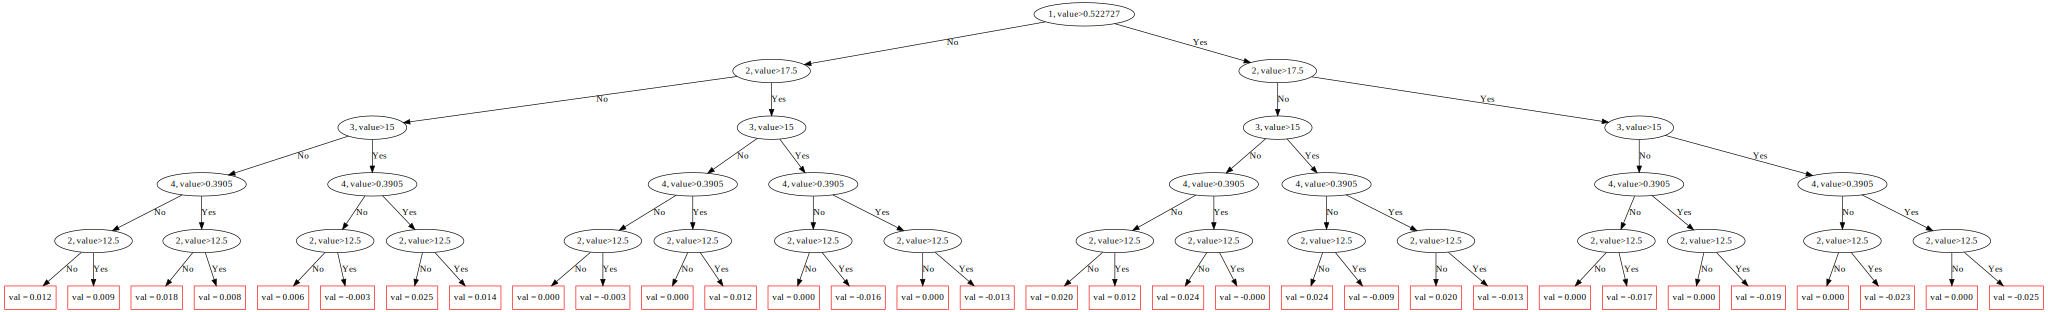

In [103]:
#可视化
import catboost
from catboost import  Pool
from catboost.datasets import titanic

car.plot_tree(
    tree_idx=0,
    pool=None
)

### 特征图

1    0.171536
2    0.156066
3    0.439767
4    0.122060
5    0.110572
dtype: float64
5    0.110572
4    0.122060
2    0.156066
1    0.171536
3    0.439767
dtype: float64
[5, 4, 2, 1, 3]
[0.11057164 0.12205955 0.15606579 0.17153605 0.43976698]


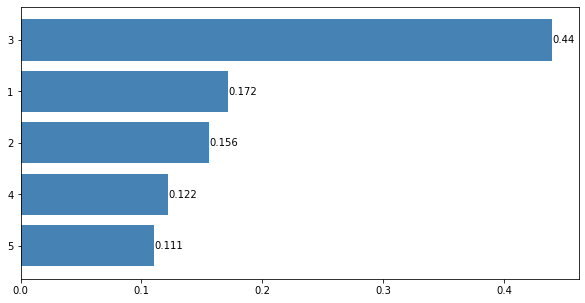

In [108]:
#绘制特征重要性
import matplotlib.pyplot as plt
importances = car.get_feature_importance()
total = 0
for i in importances:
    total += i
#获取特征标签
Impt_Series = pd.Series(importances/total, index = data.iloc[:,:5].columns)
print(Impt_Series)


#对特征影响大小进行排列
# Impt_Series.sort_values(ascending = True).plot('barh')
Impt_Series = Impt_Series.sort_values(ascending = True)

print(Impt_Series)
print(list(Impt_Series.index))
Y = list(Impt_Series.index)
# 绘制条形图
plt.figure(figsize=(10,5)) 
plt.barh(range(len(Y)), # 指定条形图y轴的刻度值
        Impt_Series.values, # 指定条形图x轴的数值
        tick_label = Y, # 指定条形图y轴的刻度标签
        color = 'steelblue', # 指定条形图的填充色
       )

print(Impt_Series.values)
# print()
for y,x in enumerate(Impt_Series.values):
    plt.text(x+0.0001,y,'%s' %round(x,3),va='center')
plt.show()